In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten,
    Dense, Dropout, Concatenate, BatchNormalization,
    GlobalAveragePooling1D, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import joblib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
SAMPLE_RATE = 22050
DURATION = 3  # seconds per segment
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MELS = 128

# ✅ Update paths according to your Drive structure
DATASET_PATH = "/content/drive/MyDrive/genres_original"
TEST_FILE = "/content/drive/MyDrive/Data/test_music.wav"


In [ ]:
def load_data(dataset_path, max_files_per_genre=50):
    X_wave, X_mel, y = [], [], []
    genres = os.listdir(dataset_path)

    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        files = [f for f in os.listdir(genre_path) if f.endswith(".wav")]
        files = files[:max_files_per_genre]  # ✅ Take only first 50 files per genre

        print(f"📂 Loading {len(files)} files from genre: {genre}")

        for file in files:
            file_path = os.path.join(genre_path, file)
            try:
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            except Exception as e:
                print(f"⚠ Skipping {file_path} due to error: {e}")
                continue

            for start in range(0, len(signal)-SAMPLES_PER_TRACK, SAMPLES_PER_TRACK):
                segment = signal[start:start+SAMPLES_PER_TRACK]
                if len(segment) == SAMPLES_PER_TRACK:
                    # Normalize waveform
                    segment = segment / np.max(np.abs(segment))
                    X_wave.append(segment[..., np.newaxis])

                    # Mel Spectrogram
                    mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=N_MELS)
                    mel_db = librosa.power_to_db(mel, ref=np.max)
                    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
                    X_mel.append(mel_db[..., np.newaxis])

                    y.append(genre)

    print(f"✅ Total segments: {len(y)}")
    return np.array(X_wave), np.array(X_mel), np.array(y)


In [ ]:
X_wave, X_mel, y = load_data(DATASET_PATH, max_files_per_genre=50)
print(f"✅ Loaded: {X_wave.shape[0]} samples")


📂 Loading 50 files from genre: disco
📂 Loading 50 files from genre: rock
📂 Loading 50 files from genre: reggae
📂 Loading 50 files from genre: pop
📂 Loading 50 files from genre: jazz
📂 Loading 50 files from genre: metal
📂 Loading 50 files from genre: country
📂 Loading 50 files from genre: classical
📂 Loading 50 files from genre: blues
📂 Loading 50 files from genre: hiphop
✅ Total segments: 4990
✅ Loaded: 4990 samples


In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(set(y)))

num_classes = len(encoder.classes_)
joblib.dump(encoder, "label_encoder100.pkl")
print("💾 LabelEncoder saved as label_encoder50.pkl")

Xw_train, Xw_test, Xm_train, Xm_test, y_train, y_test = train_test_split(
    X_wave, X_mel, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)


💾 LabelEncoder saved as label_encoder50.pkl


In [ ]:
# Waveform branch (1D CNN)
input_wave = Input(shape=(SAMPLES_PER_TRACK, 1))
x = Conv1D(32, 9, activation='relu', padding="same")(input_wave)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 9, activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 9, activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling1D()(x)

# Mel spectrogram branch (2D CNN)
input_mel = Input(shape=(N_MELS, X_mel.shape[2], 1))
y = Conv2D(32, (3,3), activation='relu', padding="same")(input_mel)
y = BatchNormalization()(y)
y = MaxPooling2D((2,2))(y)
y = Conv2D(64, (3,3), activation='relu', padding="same")(y)
y = BatchNormalization()(y)
y = MaxPooling2D((2,2))(y)
y = Conv2D(128, (3,3), activation='relu', padding="same")(y)
y = BatchNormalization()(y)
y = GlobalAveragePooling2D()(y)

# Merge branches
combined = Concatenate()([x, y])
z = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(combined)
z = Dropout(0.5)(z)
output = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[input_wave, input_mel], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 66150, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 130,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 66150, 32) │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 130,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 66150, 32) │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 130,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 22050, 32) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 65,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 22050, 64) │     18,496 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 65,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22050, 64) │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 65,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 7350, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 7350, 128) │     73,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7350, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]  

 Total params: 221,322 (864.54 KB)

 Trainable params: 220,426 (861.04 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(
    [Xw_train, Xm_train], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 489ms/step - accuracy: 0.2834 - loss: 2.0794 - val_accuracy: 0.1527 - val_loss: 2.3382
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 310ms/step - accuracy: 0.4455 - loss: 1.6510 - val_accuracy: 0.0914 - val_loss: 2.4344
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.5142 - loss: 1.4473 - val_accuracy: 0.1126 - val_loss: 2.5558
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 314ms/step - accuracy: 0.5611 - loss: 1.3489 - val_accuracy: 0.1452 - val_loss: 2.5111
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.5815 - loss: 1.2631 - val_accuracy: 0.2553 - val_loss: 2.2060
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.6252 - loss: 1.1776 - val_accuracy: 0.4230 - val_loss: 1.6365
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 314ms/step - accuracy: 0.6443 - loss: 1.1068 - val_accuracy: 0.5519 - val_loss: 1.3107
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - accuracy: 0.6608 -

In [ ]:
test_loss, test_acc = model.evaluate([Xw_test, Xm_test], y_test)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8721 - loss: 0.4066
✅ Test Accuracy: 87.37%


In [ ]:
model.save("/content/drive/MyDrive/DL/music_genre_model100.h5")
print("💾 Model saved in Google Drive")


💾 Model saved in Google Drive


In [ ]:
def predict_genre(file_path, model, encoder):
    try:
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Trim or pad to fixed length
        if len(signal) < SAMPLES_PER_TRACK:
            signal = np.pad(signal, (0, SAMPLES_PER_TRACK - len(signal)))
        else:
            signal = signal[:SAMPLES_PER_TRACK]

        # Normalize
        signal = signal / np.max(np.abs(signal))
        X_wave = signal[..., np.newaxis][np.newaxis, ...]

        # Mel spectrogram
        mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
        X_mel = mel_db[..., np.newaxis][np.newaxis, ...]

        # Predict
        prediction = model.predict([X_wave, X_mel])
        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_genre = encoder.inverse_transform([predicted_index])[0]
        confidence = prediction[0][predicted_index]

        print(f"🎵 Predicted genre: {predicted_genre} ({confidence*100:.2f}% confidence)")
        return predicted_genre, confidence

    except Exception as e:
        print(f"⚠ Error predicting genre for {file_path}: {e}")
        return None


In [ ]:
predict_genre(TEST_FILE, model, encoder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🎵 Predicted genre: classical (85.27% confidence)


(np.str_('classical'), np.float32(0.8526518))

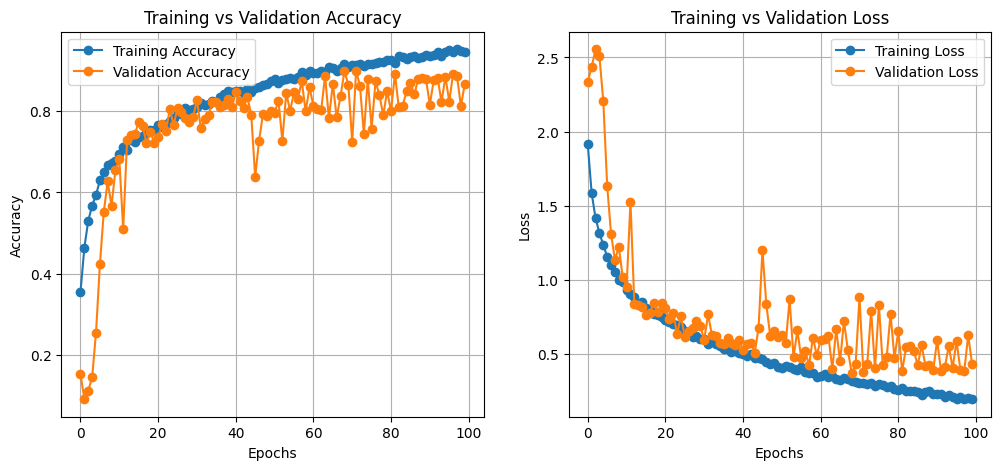

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


<Figure size 1000x800 with 0 Axes>

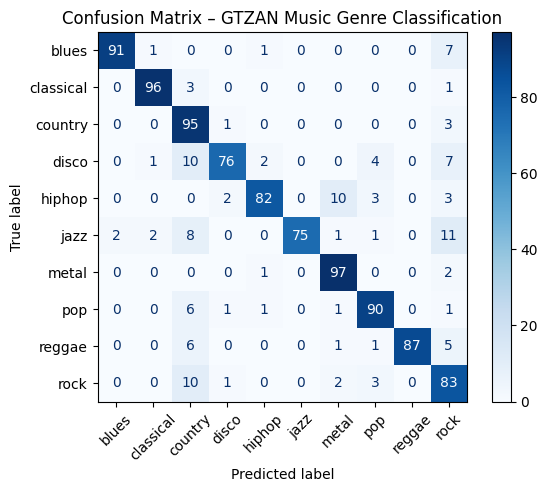

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes on test set
y_pred_probs = model.predict([Xw_test, Xm_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_

# Display confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix – GTZAN Music Genre Classification")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))
